In [2]:
import gymnasium as gym
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

### Setup

In [ ]:
# Training hyperparameters
learning_rate = 0.1  # alpha
discount_factor = 0.95  # gamma
episodes = 25000  # Number of training episodes
show_every = 1000  # How often to print progress
render = False
epsilon = 1.0  # Initial exploration rate
min_epsilon = 0.01  # Minimum exploration rate
epsilon_decay_rate = 0.9995  # epsilon decay rate

# State discretization (number of buckets for each observation dimension)
# (Cart Position, Cart Velocity, Pole Angle, Pole Velocity)
num_buckets = (10, 10, 12, 12)

# State bounds (limits)
# (Cart Position, Cart Velocity, Pole Angle, Pole Velocity)
state_bounds = [
    (-4.8, 4.8),
    (-4., 4.),
    (-0.418, 0.418),  # 24 deg
    (-4., 4.),
]
# ^these are for binning; these are not actual limits on the environment

In [4]:
# Environment initialization
env = gym.make("CartPole-v1", render_mode="human" if render else None)
print(f"Action Space: {env.action_space}")  # 0: push left, 1: push right
print(f"Observation Space: {env.observation_space}")

Action Space: Discrete(2)
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [5]:
# Q-Table initialization
q_table_shape = num_buckets + (env.action_space.n,)
q_table = np.zeros(q_table_shape)
print(f"Q Table shape: {q_table.shape}")

Q Table shape: (10, 10, 12, 12, 2)


In [6]:
def discretize_state(observation, state_bounds, num_buckets):
    """Convert a continuous observation into a discrete state using bucketing."""
    discrete_state = []
    for i, (obs_val, (low, high), num_b) in enumerate(zip(observation, state_bounds, num_buckets)):
        bucket_size = (high - low) / num_b
        bucket_index = int((obs_val - low) / bucket_size)
        if bucket_index not in range(num_buckets[i]):
            bucket_index = max(0, min(bucket_index, num_buckets[i] - 1))  # Clamp to valid range
        discrete_state.append(bucket_index)
    return tuple(discrete_state)

### Training Loop

In [ ]:
total_rewards = []
highest_reward = 0

for episode in range(episodes):
    # Initialize
    observation, info = env.reset()
    current_discrete_state = discretize_state(observation, state_bounds, num_buckets)
    total_reward = 0
    terminated = False
    truncated = False

    # Decide whether to render this episode
    render_this_episode = episode % show_every == 0

    while not terminated and not truncated:
        # Render
        if render_this_episode and render:
            try:
                env.render()
                time.sleep(0.01)  # 100 FPS maximum
            except Exception as e:
                print(f"Could not render: {e}")
                pass

        # Epsilon-greedy action selection
        if np.random.random() > epsilon:
            action = np.argmax(q_table[current_discrete_state])  # Exploit
        else:
            action = env.action_space.sample()  # Explore

        # Take action and time step
        next_observation, reward, terminated, truncated, info = env.step(action)
        next_discrete_state = discretize_state(next_observation, state_bounds, num_buckets)

        # Update Q table
        if not terminated:
            # Estimate maximum Q-value @ t+1
            max_future_q = np.max(q_table[next_discrete_state])

            # Current Q-value
            current_q = q_table[current_discrete_state + (action,)]

            # New Q from Bellman equation
            new_q = current_q + learning_rate * (
                reward + discount_factor * max_future_q - current_q
            )

            # Update
            q_table[current_discrete_state + (action,)] = new_q

        elif terminated:
            q_table[current_discrete_state + (action,)] = 0

        # State transition
        current_discrete_state = next_discrete_state
        total_reward += reward

    # Decay epsilon after episode
    epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)

    # Track rewards and print progress
    total_rewards.append(total_reward)
    if total_reward > highest_reward:
        highest_reward = total_reward

    if episode % show_every == 0:
        avg_reward = sum(total_rewards[-show_every:]) / len(
            total_rewards[-show_every:]
        )
        print(
            f"Episode: {episode:5} | Avg Reward (last {show_every}): {avg_reward:6.2f} | Epsilon: {epsilon:6.4f} | Highest: {highest_reward:5}"
        )

In [ ]:
# Save trained model
data = {
    "q_table": q_table,
    "total_rewards": total_rewards
    }
with open("data_QL.pkl", "wb") as f:
    pickle.dump(data, f)

### Postprocessing

In [7]:
# Load trained model
with open("data_QL.pkl", "rb") as f:
    data = pickle.load(f)
    q_table = data["q_table"]
    total_rewards = data["total_rewards"]

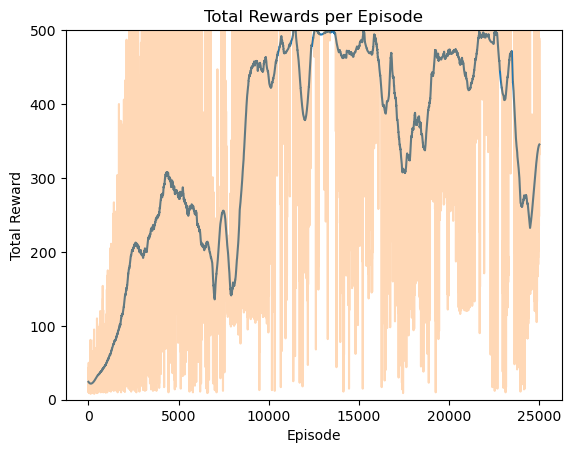

In [10]:
# Plot
plt.plot(savgol_filter(total_rewards, 1001, 3), label="filtered")
plt.plot(total_rewards, alpha=0.3, label="raw")
plt.title("Total Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.ylim([0, 500])
plt.show()

In [9]:
# Render a single episode using the trained Q-table
env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset()
discrete_state = discretize_state(observation, state_bounds, num_buckets)
terminated = False
truncated = False

while not terminated and not truncated:
    action = np.argmax(q_table[discrete_state])
    next_observation, reward, terminated, truncated, info = env.step(action)
    discrete_state = discretize_state(next_observation, state_bounds, num_buckets)
    time.sleep(0.02)  # 50 FPS max

env.close()

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
